# Machine learning - feature based

This notebook does the following:

1. Loads time windowed physiological features
2. Selects features for ML
3. Creates ML models for each classifier
4. Runs ML pipeline for each classifier and modality
5. Creates results table containing mean results
6. Plots results using barplot and heatmap

Input: 'temp/windowed_features.csv'

Output:
1. 'classification_combined.csv' - csv file containing detailed training results for all participants, classifiers and modalities
2. 'classification_results.tex' - overview results table in form of a latex table containing mean training results for all classifiers and modalities
3. 'classification_results.pdf' - barplot depicting F1 score values for each classifier and modality
4. 'classification_results_heatmap.pdf' - heatmap depicting F1 scores for each classifier and modality per each participant

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Create new directory for notebook output
notebook_temp_dir = os.path.join(os.getcwd(), "temp", "4_machine_learning")

if not os.path.exists(notebook_temp_dir):
    os.makedirs(notebook_temp_dir)

In [3]:
# Load file
features_file_directory = os.path.join(os.getcwd(), 'temp', 'windowed_features.csv')
df = pd.read_csv(features_file_directory, index_col=0)

In [4]:
# Select only condition segment and drop nan values
df = df[df['Segment']=='gas_inhalation']
df = df.dropna()

In [5]:
# Used to define the segments of interest and the mapping for classifiers
CLASSES_MAPPING = {
            "AIR": 0,
            "CO2": 1,
            }
CLASSES_MAPPING_INVERSE = { v:k for k,v in CLASSES_MAPPING.items()}

In [ ]:
data_X = df
data_X = data_X.reset_index(drop=True)
data_X

<Axes: ylabel='Condition'>

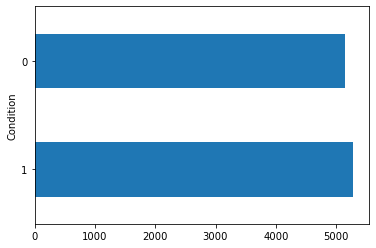

In [7]:
data_Y = df 
data_Y = data_Y.reset_index(drop=True)
data_Y = data_Y["Condition"].map(CLASSES_MAPPING)
data_Y.value_counts().plot.barh()

In [ ]:
data_participant = df
data_participant = data_participant.reset_index(drop=True)
data_participant = data_participant['participant_number']
data_participant.value_counts().plot.bar()

In [9]:
hrv_colnames = data_X.columns[ [ (col.startswith("HRV") | col.startswith("HeartRate") | col.startswith("Ppg/")| col.startswith("PPG")) for col in data_X.columns] ].sort_values().values
hrv_colnames

array(['HRV_IQRNN', 'HRV_MeanNN', 'HRV_MedianNN', 'HRV_RMSSD', 'HRV_SDNN',
       'HRV_SDSD', 'HeartRate/Average_1st_derivative_mean',
       'HeartRate/Average_1st_derivative_std',
       'HeartRate/Average_2nd_derivative_mean',
       'HeartRate/Average_2nd_derivative_std', 'HeartRate/Average_iqr',
       'HeartRate/Average_max', 'HeartRate/Average_mean',
       'HeartRate/Average_median', 'HeartRate/Average_min',
       'HeartRate/Average_range', 'HeartRate/Average_std',
       'PPG_Rate_Mean', 'Ppg/Raw.ppg_1st_derivative_mean',
       'Ppg/Raw.ppg_1st_derivative_std',
       'Ppg/Raw.ppg_2nd_derivative_mean',
       'Ppg/Raw.ppg_2nd_derivative_std', 'Ppg/Raw.ppg_iqr',
       'Ppg/Raw.ppg_max', 'Ppg/Raw.ppg_mean', 'Ppg/Raw.ppg_median',
       'Ppg/Raw.ppg_min', 'Ppg/Raw.ppg_range', 'Ppg/Raw.ppg_std'],
      dtype=object)

In [10]:
imu_colnames = data_X.columns[ [ (col.startswith("Accelerometer")) | (col.startswith("Gyroscope")) for col in data_X.columns] ].sort_values().values
imu_colnames

array(['Accelerometer/Raw.x_1st_derivative_mean',
       'Accelerometer/Raw.x_1st_derivative_std',
       'Accelerometer/Raw.x_2nd_derivative_mean',
       'Accelerometer/Raw.x_2nd_derivative_std',
       'Accelerometer/Raw.x_iqr', 'Accelerometer/Raw.x_max',
       'Accelerometer/Raw.x_mean', 'Accelerometer/Raw.x_median',
       'Accelerometer/Raw.x_min', 'Accelerometer/Raw.x_range',
       'Accelerometer/Raw.x_std',
       'Accelerometer/Raw.y_1st_derivative_mean',
       'Accelerometer/Raw.y_1st_derivative_std',
       'Accelerometer/Raw.y_2nd_derivative_mean',
       'Accelerometer/Raw.y_2nd_derivative_std',
       'Accelerometer/Raw.y_iqr', 'Accelerometer/Raw.y_max',
       'Accelerometer/Raw.y_mean', 'Accelerometer/Raw.y_median',
       'Accelerometer/Raw.y_min', 'Accelerometer/Raw.y_range',
       'Accelerometer/Raw.y_std',
       'Accelerometer/Raw.z_1st_derivative_mean',
       'Accelerometer/Raw.z_1st_derivative_std',
       'Accelerometer/Raw.z_2nd_derivative_mean',
       'A

In [11]:
emg_amp_colnames = data_X.columns[ [ (col.startswith("Emg/Amplitude")) for col in data_X.columns] ].sort_values().values
emg_amp_colnames

array(['Emg/Amplitude[CenterCorrugator]_1st_derivative_mean',
       'Emg/Amplitude[CenterCorrugator]_1st_derivative_std',
       'Emg/Amplitude[CenterCorrugator]_2nd_derivative_mean',
       'Emg/Amplitude[CenterCorrugator]_2nd_derivative_std',
       'Emg/Amplitude[CenterCorrugator]_iqr',
       'Emg/Amplitude[CenterCorrugator]_max',
       'Emg/Amplitude[CenterCorrugator]_mean',
       'Emg/Amplitude[CenterCorrugator]_median',
       'Emg/Amplitude[CenterCorrugator]_min',
       'Emg/Amplitude[CenterCorrugator]_range',
       'Emg/Amplitude[CenterCorrugator]_std',
       'Emg/Amplitude[LeftFrontalis]_1st_derivative_mean',
       'Emg/Amplitude[LeftFrontalis]_1st_derivative_std',
       'Emg/Amplitude[LeftFrontalis]_2nd_derivative_mean',
       'Emg/Amplitude[LeftFrontalis]_2nd_derivative_std',
       'Emg/Amplitude[LeftFrontalis]_iqr',
       'Emg/Amplitude[LeftFrontalis]_max',
       'Emg/Amplitude[LeftFrontalis]_mean',
       'Emg/Amplitude[LeftFrontalis]_median',
       'Emg/Ampl

In [12]:
emg_cont_colnames = data_X.columns[ [ (col.startswith("Emg/Contact")) for col in data_X.columns] ].sort_values().values
emg_cont_colnames

array(['Emg/Contact[CenterCorrugator]_1st_derivative_mean',
       'Emg/Contact[CenterCorrugator]_1st_derivative_std',
       'Emg/Contact[CenterCorrugator]_2nd_derivative_mean',
       'Emg/Contact[CenterCorrugator]_2nd_derivative_std',
       'Emg/Contact[CenterCorrugator]_iqr',
       'Emg/Contact[CenterCorrugator]_max',
       'Emg/Contact[CenterCorrugator]_mean',
       'Emg/Contact[CenterCorrugator]_median',
       'Emg/Contact[CenterCorrugator]_min',
       'Emg/Contact[CenterCorrugator]_range',
       'Emg/Contact[CenterCorrugator]_std',
       'Emg/Contact[LeftFrontalis]_1st_derivative_mean',
       'Emg/Contact[LeftFrontalis]_1st_derivative_std',
       'Emg/Contact[LeftFrontalis]_2nd_derivative_mean',
       'Emg/Contact[LeftFrontalis]_2nd_derivative_std',
       'Emg/Contact[LeftFrontalis]_iqr', 'Emg/Contact[LeftFrontalis]_max',
       'Emg/Contact[LeftFrontalis]_mean',
       'Emg/Contact[LeftFrontalis]_median',
       'Emg/Contact[LeftFrontalis]_min',
       'Emg/Contact[

In [13]:
gsr_colnames = data_X.columns[ [ (col.startswith("Biopac_GSR")) | (col.startswith("SCR")) | (col.startswith("EDA")) for col in data_X.columns] ].sort_values().values
gsr_colnames

array(['Biopac_GSR_1st_derivative_mean', 'Biopac_GSR_1st_derivative_std',
       'Biopac_GSR_2nd_derivative_mean', 'Biopac_GSR_2nd_derivative_std',
       'Biopac_GSR_iqr', 'Biopac_GSR_max', 'Biopac_GSR_mean',
       'Biopac_GSR_median', 'Biopac_GSR_min', 'Biopac_GSR_range',
       'Biopac_GSR_std', 'EDA_Tonic_SD', 'SCR_Peaks_Amplitude_Mean',
       'SCR_Peaks_N'], dtype=object)

In [14]:
rsp_colnames = data_X.columns[ [ (col.startswith("Biopac_RSP")) | (col.startswith("RSP")) for col in data_X.columns] ].sort_values().values
rsp_colnames

array(['Biopac_RSP_1st_derivative_mean', 'Biopac_RSP_1st_derivative_std',
       'Biopac_RSP_2nd_derivative_mean', 'Biopac_RSP_2nd_derivative_std',
       'Biopac_RSP_iqr', 'Biopac_RSP_max', 'Biopac_RSP_mean',
       'Biopac_RSP_median', 'Biopac_RSP_min', 'Biopac_RSP_range',
       'Biopac_RSP_std', 'RSP_Amplitude_Mean', 'RSP_Phase_Duration_Ratio',
       'RSP_Rate_Mean'], dtype=object)

In [15]:
pupil_size_colnames = data_X.columns[ [ (col.startswith("VerboseData")) for col in data_X.columns] ].sort_values().values
pupil_size_colnames

array(['VerboseData.Left.PupilDiameterMm_1st_derivative_mean',
       'VerboseData.Left.PupilDiameterMm_1st_derivative_std',
       'VerboseData.Left.PupilDiameterMm_2nd_derivative_mean',
       'VerboseData.Left.PupilDiameterMm_2nd_derivative_std',
       'VerboseData.Left.PupilDiameterMm_iqr',
       'VerboseData.Left.PupilDiameterMm_max',
       'VerboseData.Left.PupilDiameterMm_mean',
       'VerboseData.Left.PupilDiameterMm_median',
       'VerboseData.Left.PupilDiameterMm_min',
       'VerboseData.Left.PupilDiameterMm_range',
       'VerboseData.Left.PupilDiameterMm_std',
       'VerboseData.Right.PupilDiameterMm_1st_derivative_mean',
       'VerboseData.Right.PupilDiameterMm_1st_derivative_std',
       'VerboseData.Right.PupilDiameterMm_2nd_derivative_mean',
       'VerboseData.Right.PupilDiameterMm_2nd_derivative_std',
       'VerboseData.Right.PupilDiameterMm_iqr',
       'VerboseData.Right.PupilDiameterMm_max',
       'VerboseData.Right.PupilDiameterMm_mean',
       'VerboseD

In [16]:
print(f"HRV {hrv_colnames.size}")
print(f"IMU {imu_colnames.size}")
print(f"EMG Amplitude {emg_amp_colnames.size}")
print(f"EMG Contact {emg_cont_colnames.size}")
print(f"GSR {gsr_colnames.size}")
print(f"RSP {rsp_colnames.size}")
print(f"Pupil Size {pupil_size_colnames.size}")

HRV 29
IMU 66
EMG Amplitude 77
EMG Contact 77
GSR 14
RSP 14
Pupil Size 22


In [17]:
# FEATURE-BASED CLASSIFIERS CLASSIFIERS SETUP
MC_RANDOM_SEED = 1234
N_SPLITS_CV = 10 # Number of folds for Cross-validation

# Scoring parameters: https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter
SCORING_METRICS = ["accuracy", "f1_macro", "precision_macro", "recall_macro"]

In [ ]:
## Example of iterator for Cross-validation per subject

# Feature subset
feature_subset_colnames = hrv_colnames   # imu_colnames, emg_amp_colnames, emg_cont_colnames

# Features
x = data_X[feature_subset_colnames]
# Target
y = data_Y
# Groups indices (participants' ids)
group_cv = data_participant

loso_cv = LeaveOneGroupOut()
cv_splits = loso_cv.split(x, y, groups=group_cv)
for trn_idx, tst_idx in cv_splits:
    print("TRN: %s \t TST: %s" % (data_participant[trn_idx].unique(), data_participant[tst_idx].unique()))

In [ ]:
# Deep learner Keras CLassifier

from scikeras.wrappers import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

from tensorflow import keras
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="relu"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(3, activation="sigmoid"))
    return model

clf = KerasClassifier(
    model=get_clf,
    loss="CategoricalCrossentropy",
    optimizer="adam",
    optimizer__learning_rate=0.1,
    model__hidden_layer_sizes=(100,),
    model__dropout=0.5,
    verbose=False,
)

In [ ]:
data_modality_colnames = { 
            "hrv": hrv_colnames, 
            "imu": imu_colnames, 
            "emg_amp": emg_amp_colnames,
            "emg_cont": emg_cont_colnames,
            "gsr": gsr_colnames,
            "rsp": rsp_colnames,
            "pupil_size": pupil_size_colnames,
            "all": list(hrv_colnames) + list(imu_colnames) + list(emg_amp_colnames) + list(emg_cont_colnames) + list(gsr_colnames) + list(rsp_colnames) + list(pupil_size_colnames),
    }

# ClassifierName: {"clf":model, "pgrid":parameters)
classifiers_hyperparams = {
    # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html
    "RR": {    "clf": RidgeClassifier(alpha=0.01, max_iter=1000),
                        "pgrid": {
                            'alpha': np.logspace(-5, 5,11) 
                        }},
    # https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
    "C-SVC": {    "clf": SVC(kernel='rbf', gamma='auto', C = 1),
                        "pgrid": {
                            'C': [1], 'gamma': [0.001]
                        }},
    # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
    "RF": {             "clf": RandomForestClassifier(criterion='entropy', random_state=MC_RANDOM_SEED, class_weight="balanced"),
                    "pgrid": {
                        'n_estimators': [20],
                        'max_depth': [5]
                    }},
    # https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    "KNN": {            "clf": KNeighborsClassifier(),
                        "pgrid": {
                            'n_neighbors': [1, 5, 11, 15]
                        }},
    "DL": {
    "clf": KerasClassifier(
        model=get_clf,
        loss="categorical_crossentropy",
        optimizer="adam",
        optimizer__learning_rate=0.1,
        model__hidden_layer_sizes=(100,),
        model__dropout=0.5,
        verbose=False,
    ),
    "pgrid": {
        'optimizer__learning_rate': [0.05, 0.001],
        'model__hidden_layer_sizes': [(100, ), (50, 50, )],
        'model__dropout': [0, 0.5],
    },
    },

    }

In [ ]:
DATASET_POSTPROCESSED_FILENAME = os.path.join(notebook_temp_dir, 'classification_combined.csv')

output_filename = DATASET_POSTPROCESSED_FILENAME

# Variable to store the final dataset
df_results_hyperparam_opt = None

# Check if file already exists
if (os.path.isfile(output_filename)):
    df_results_hyperparam_opt = pd.read_csv(output_filename)
    print(f"Combined file loaded from path!")
# Otherwise generate it
else:
    print(f"Generating classification files!")
    
    ## Iteration per data type
    for modality_name, modality_colnames in data_modality_colnames.items(): 

        # modality_name = "hrv"
        # modality_colnames = data_modality_colnames[modality_name]
        #### ABOVE FOR TESTING

        # Subset of features
        data_mod_x = data_X[modality_colnames].values.copy()   # Features
        data_mod_y = data_Y.values.copy()       # Target
        subject_ids = data_participant.values.copy()  # Groups indices (participants' ids)

        # Split dataset with LOSO-CV
        cv_loso_subj = LeaveOneGroupOut()
        cv_splits_subjects = cv_loso_subj.split(data_mod_x, data_mod_y, groups=subject_ids)

        # Iteration per subject (participant)
        for trn_subj_idx, tst_subj_idx in cv_splits_subjects:

            # The dataset that is not belonging to the TEST subject will be further divided for hyperparam optimization.
            x = data_mod_x[trn_subj_idx]             # Data to be used to create a model for TEST subject
            x_test_subj = data_mod_x[tst_subj_idx]
            y = data_mod_y[trn_subj_idx]
            y_test_subj = data_mod_y[tst_subj_idx]
            subjects_cv = data_participant[trn_subj_idx].values
            subject_in_test_set = np.unique(data_participant[tst_subj_idx].values)[0]   # Store the participant id in the test set
            
            # print(f"TRAIN SUBJECT IDS: {np.unique(subjects_cv)} \t TEST SUBJECT: {subject_in_test_set}")
            # print(f"SHAPE : x:{x.shape}, x_test_subj:{x_test_subj.shape}, y:{y.shape}, y_test_subj:{y_test_subj.shape}, subjects_cv:{subjects_cv.shape}")

            # Create pipeline
            #scaler = StandardScaler().fit(x)
            #x_scaled = scaler.transform(x)

            for clf_name, clf_data in classifiers_hyperparams.items(): 
                # clf_name = "GaussianSVM"
                # clf_data = classifiers_hyperparams[clf_name]
                #### ABOVE FOR TESTING

                clf = clf_data["clf"]
                pgrid = clf_data["pgrid"]

                # Leave-One-Subject-Out CV also to optimize the hyperparameters and select a model
                cv_loso_fold = LeaveOneGroupOut()
                cv_fold_per_subject = cv_loso_subj.split(x, y, groups = subjects_cv)    

                gr_search = GridSearchCV(clf, pgrid, cv=cv_fold_per_subject, scoring=SCORING_METRICS, refit="accuracy", n_jobs=-1)
                gr_search.fit(x, y)

                # Get results per fold and add best results
                df_this_hyperparam_optim = pd.DataFrame(gr_search.cv_results_)
                df_this_hyperparam_optim.insert(0,"best_trn_score_", str(gr_search.best_score_))
                df_this_hyperparam_optim.insert(0,"best_params_", str(gr_search.best_params_))
                df_this_hyperparam_optim.insert(0,"best_estimator_", str(gr_search.best_estimator_))

                # Insert general information in long format
                df_this_hyperparam_optim.insert(0,"classifier", clf_name)
                df_this_hyperparam_optim.insert(0, "test_subject_id",subject_in_test_set)
                df_this_hyperparam_optim.insert(0, "data_modality", modality_name)
                df_this_hyperparam_optim.insert(0, "pipeline_step", "hyperparam_opt")

                # Append to the main dataframe with the results 
                df_results_hyperparam_opt = df_this_hyperparam_optim if (df_results_hyperparam_opt is None) else pd.concat([df_results_hyperparam_opt, df_this_hyperparam_optim], axis=0, ignore_index=True)

                print(f"Data modality: {modality_name} | Clf: {clf_name} | Subject: {subject_in_test_set} ")

                # Saving .csv
                output_filename = os.path.join(notebook_temp_dir, 'classification_' + clf_name + '.csv')
                df_results_hyperparam_opt.to_csv( output_filename, index=False)

            # End of classifiers
        # End of subjects

        # # Saving .csv every iteration
        # df_results_hyperparam_opt.to_csv( output_filename )
    print("\n\n End")

In [238]:
rf = pd.read_csv(os.path.join(notebook_temp_dir, 'classification_RF.csv'))
knn = pd.read_csv(os.path.join(notebook_temp_dir, 'classification_KNN.csv'))
rr = pd.read_csv(os.path.join(notebook_temp_dir, 'classification_RR.csv'))
c_svc = pd.read_csv(os.path.join(notebook_temp_dir, 'classification_C-SVC.csv'))



# Concatenate the dataframes vertically
combined_df = pd.concat([rf, knn, rr, c_svc])

# Reset the index of the combined dataframe
combined_df = combined_df.reset_index(drop=True)
df_results_hyperparam_opt = combined_df

In [ ]:
# Iterate over participants to know the best model per subject and its hyperparams.
for participant in df_results_hyperparam_opt.test_subject_id.unique():
    # participant = 0
    # for clf_name, clf_data in classifiers_hyperparams.items():
    query = ((df_results_hyperparam_opt.test_subject_id == participant) & \
                # (df_results_hyperparam_opt.rank_test_accuracy == 1) & \
                # (df_results_hyperparam_opt.classifier == clf_name) & \
                    (df_results_hyperparam_opt.data_modality == "all") )
    best_results_participant = df_results_hyperparam_opt[ query ]
    best_classifier_gridsearch = best_results_participant[ best_results_participant.mean_test_accuracy == best_results_participant.mean_test_accuracy.max() ]
    best_clf_name = best_classifier_gridsearch.classifier
    
    # Apply the classification on the test subject
    print(f"P{participant} - Best clf: {best_clf_name}\n\tBest performance {best_classifier_gridsearch.mean_test_accuracy.values}\n\tBest params {best_classifier_gridsearch.params.values}")
        

In [ ]:
# Select the results based on the hyperparameters combination with highest f1-score
df_summary_classif = df_results_hyperparam_opt[ (df_results_hyperparam_opt.rank_test_f1_macro == 1) ]
df_summary_classif.shape

In [ ]:
# Summary of test results
data_results_main = df_summary_classif.groupby(["test_subject_id", "data_modality","classifier"]).first()[ ["mean_test_accuracy","mean_test_f1_macro"] ]
data_results_main

In [ ]:
# Rename the columns
data_results_main = data_results_main.reset_index()
data_results_main.columns = ["Subject", "Data Modality", "Classifier", "Accuracy", "F1-score"]
data_results_main["Data Modality"].replace( dict(zip(["all","emg_amp","emg_cont","hrv","imu"],["All","EMG A", "EMG C", "HRV", "IMU"])), inplace=True )
data_results_main = data_results_main.set_index(["Subject", "Data Modality", "Classifier"])
data_results_main

In [243]:
df_table = data_results_main.stack().reset_index()
df_table = df_table.rename(columns={"level_3":"Metric",0:"Value"})
#df_table_mean = df_table.groupby(["Data Modality","Classifier","Metric"]).mean().drop("Subject",axis=1).unstack(["Classifier","Metric"])
df_table_mean = df_table.groupby(["Data Modality", "Classifier", "Metric"]).mean().unstack(["Classifier", "Metric"]).droplevel(0, axis=1)
df_table_mean

C:\Users\m\AppData\Local\Temp\ipykernel_14776\3816359988.py:4: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_table_mean = df_table.groupby(["Data Modality", "Classifier", "Metric"]).mean().unstack(["Classifier", "Metric"]).droplevel(0, axis=1)


Classifier        C-SVC                 KNN  ...        RF        RR          
Metric         Accuracy  F1-score  Accuracy  ...  F1-score  Accuracy  F1-score
Data Modality                                ...                              
All            0.723752  0.698787  0.707473  ...  0.892705  0.944873  0.943129
EMG A          0.571227  0.504931  0.613388  ...  0.619999  0.624424  0.592933
EMG C          0.669747  0.631849  0.685851  ...  0.708302  0.703548  0.678523
HRV            0.692463  0.664992  0.690406  ...  0.680497  0.763270  0.741017
IMU            0.655321  0.639894  0.582187  ...  0.770236  0.823562  0.808166
gsr            0.807663  0.793559  0.771841  ...  0.784343  0.816768  0.804005
pupil_size     0.496199  0.405854  0.551809  ...  0.557496  0.636649  0.600046
rsp            0.817430  0.798760  0.880883  ...  0.876198  0.901681  0.894447

[8 rows x 8 columns]

In [244]:
df_table_std = df_table.groupby(["Data Modality","Classifier","Metric"]).std().unstack(["Classifier","Metric"])
df_table_std

C:\Users\m\AppData\Local\Temp\ipykernel_14776\2239379158.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.std is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_table_std = df_table.groupby(["Data Modality","Classifier","Metric"]).std().unstack(["Classifier","Metric"])


Value                      ...                              
Classifier        C-SVC                 KNN  ...        RF        RR          
Metric         Accuracy  F1-score  Accuracy  ...  F1-score  Accuracy  F1-score
Data Modality                                ...                              
All            0.005216  0.006157  0.005780  ...  0.007318  0.003234  0.003543
EMG A          0.003633  0.004612  0.004424  ...  0.009888  0.005404  0.003821
EMG C          0.011589  0.012635  0.008740  ...  0.013940  0.008019  0.008285
HRV            0.005398  0.006285  0.005738  ...  0.014064  0.006323  0.007209
IMU            0.004678  0.005025  0.006343  ...  0.007712  0.004448  0.005082
gsr            0.005338  0.005669  0.006230  ...  0.005547  0.005442  0.005789
pupil_size     0.023992  0.042958  0.007071  ...  0.009098  0.005168  0.005793
rsp            0.002761  0.003420  0.002836  ...  0.005859  0.002359  0.002875

[8 rows x 8 columns]

In [245]:
# Convert to a text
df_str_mean = df_table_mean.apply(lambda x: ['%.2f'%v for v in x.values])
df_str_std = df_table_std.apply(lambda x: ['%.2f'%v for v in x.values])

# df_results = (df_str_mean + "(" + df_str_std + ")")
df_results = (df_str_mean)

# Rename columns
df_results

Classifier       C-SVC               KNN  ...       RF       RR         
Metric        Accuracy F1-score Accuracy  ... F1-score Accuracy F1-score
Data Modality                             ...                           
All               0.72     0.70     0.71  ...     0.89     0.94     0.94
EMG A             0.57     0.50     0.61  ...     0.62     0.62     0.59
EMG C             0.67     0.63     0.69  ...     0.71     0.70     0.68
HRV               0.69     0.66     0.69  ...     0.68     0.76     0.74
IMU               0.66     0.64     0.58  ...     0.77     0.82     0.81
gsr               0.81     0.79     0.77  ...     0.78     0.82     0.80
pupil_size        0.50     0.41     0.55  ...     0.56     0.64     0.60
rsp               0.82     0.80     0.88  ...     0.88     0.90     0.89

[8 rows x 8 columns]

In [246]:
# Generate LaTeX table
FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME = os.path.join(notebook_temp_dir, 'classification_results.tex')
df_results.style.to_latex(FEATURE_BASED_CLASSIFIERS_RESULTS_FILENAME)

In [ ]:
# Scores across participants
df_temp_mean = data_results_main["F1-score"].reset_index()
df_temp_mean

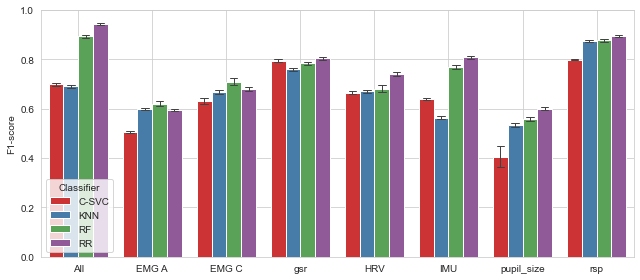

In [248]:
fig,axes = plt.subplots(1, 1, figsize=(9,4))
sns.set_style("whitegrid")
sns.barplot(ax = axes, data = df_temp_mean, x="Data Modality", y="F1-score", hue="Classifier",
                errorbar="sd", errwidth=1, capsize=0.1, palette="Set1")
# plt.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=4)
plt.xlabel(None)
plt.grid(True)
plt.ylim([0,1])

plt.tight_layout()
save_path_plot = os.path.join(notebook_temp_dir, 'classification_results.pdf')
plt.savefig(save_path_plot)

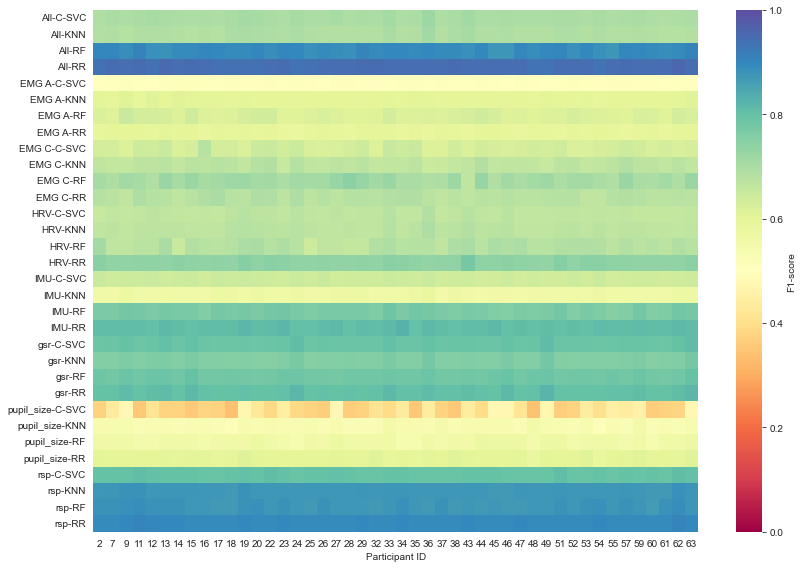

In [251]:
# F1-score per subject
fig,axes = plt.subplots(1, 1, figsize=(12,8))
heatmap_data = df_temp_mean.copy()
heatmap_data['Subject'] = heatmap_data['Subject'].str.split('_').str[0].astype(int)
heatmap_data = heatmap_data.sort_values(by='Subject')
heatmap_data = heatmap_data.pivot(index=["Data Modality","Classifier"], columns=("Subject"), values="F1-score")
sns.heatmap(heatmap_data, ax=axes, cmap="Spectral", vmin=0, vmax=1, cbar_kws={"label": "F1-score"})
plt.xlabel('Participant ID')
plt.ylabel(None)


plt.tight_layout()
save_path_plot = os.path.join(notebook_temp_dir, 'classification_results_heatmap.pdf')
plt.savefig(save_path_plot, bbox_inches='tight', pad_inches = 0)